<a href="https://colab.research.google.com/github/carbotton/taller-deep-learning/blob/main/03/Clase03_California_House_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California Housing Prices: Regresión con PyTorch y Weights & Biases

En esta notebook, implementaremos un modelo de regresión para predecir valores medianos de casas basado en un conjunto de datos de características demográficas y geográficas. Además, presentaremos los aspectos básicos del entrenamiento de modelos en PyTorch y utilizaremos la herramienta Weights & Biases (W&B) para el seguimiento y visualización de los experimentos.

## Introduction

### Objetivos

1. **Implementar un modelo de regresión** utilizando PyTorch.
2. **Configurar y utilizar W&B** para el seguimiento de métricas y visualización de resultados.

### Contenido

1. Configuración de bibliotecas y semillas para reproducibilidad.
2. Carga y exploración del dataset `housing.csv`.
3. Preparación de datos y división en conjuntos de entrenamiento y prueba.
4. Definición y entrenamiento de un modelo de regresión en PyTorch.
5. Integración de W&B para el seguimiento de experimentos y visualización de métricas.

### Sobre el conjunto de datos

Los datos se refieren a las casas que se encuentran en un determinado distrito de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Hay que tener en cuenta que los datos no están depurados, por lo que se requieren algunos pasos de preprocesamiento. El objetivo es predecir el valor medio de las casas para los distritos de California, por lo que se trata de un problema de regresión.

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

from torchinfo import summary

from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [3]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
#elif torch.backends.xpu.is_available():
#    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [5]:

BATCH_SIZE = 1024  # tamaño del batch

## Carga de datos + Exploración

In [6]:
california_housing = fetch_california_housing(as_frame=True)
target_column_name = california_housing.target_names[0]  # 'MedHouseVal'
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [7]:
df = california_housing.frame  # Convertimos el dataset en un DataFrame de pandas
df.head()  # Mostramos las primeras filas del DataFrame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [8]:
df.describe()  # Mostramos un resumen de las estadísticas del DataFrame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [9]:
# Chequear si hay valores nulos
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


Afortunadamente, el conjunto de datos no tiene valores faltantes, por lo que podemos ignorar la imputación de datos.

In [10]:
# Crear la matriz de correlación
correlation_matrix = df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

               MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
MedInc       1.000000 -0.119034  0.326895  -0.062040    0.004834  0.018766   
HouseAge    -0.119034  1.000000 -0.153277  -0.077747   -0.296244  0.013191   
AveRooms     0.326895 -0.153277  1.000000   0.847621   -0.072213 -0.004852   
AveBedrms   -0.062040 -0.077747  0.847621   1.000000   -0.066197 -0.006181   
Population   0.004834 -0.296244 -0.072213  -0.066197    1.000000  0.069863   
AveOccup     0.018766  0.013191 -0.004852  -0.006181    0.069863  1.000000   
Latitude    -0.079809  0.011173  0.106389   0.069721   -0.108785  0.002366   
Longitude   -0.015176 -0.108197 -0.027540   0.013344    0.099773  0.002476   
MedHouseVal  0.688075  0.105623  0.151948  -0.046701   -0.024650 -0.023737   

             Latitude  Longitude  MedHouseVal  
MedInc      -0.079809  -0.015176     0.688075  
HouseAge     0.011173  -0.108197     0.105623  
AveRooms     0.106389  -0.027540     0.151948  
AveBedrms    0.069721   0.0

En este momento vemos que existen relaciones fuertes entre algunas variables como `MedInc`, `HouseAge`, y `AveRooms`  con `MedHouseVal`, lo cual suena lógico. Podríamos descartar algunas variables que no aportan mucho valor al modelo, pero por simplicidad, las mantendremos todas.

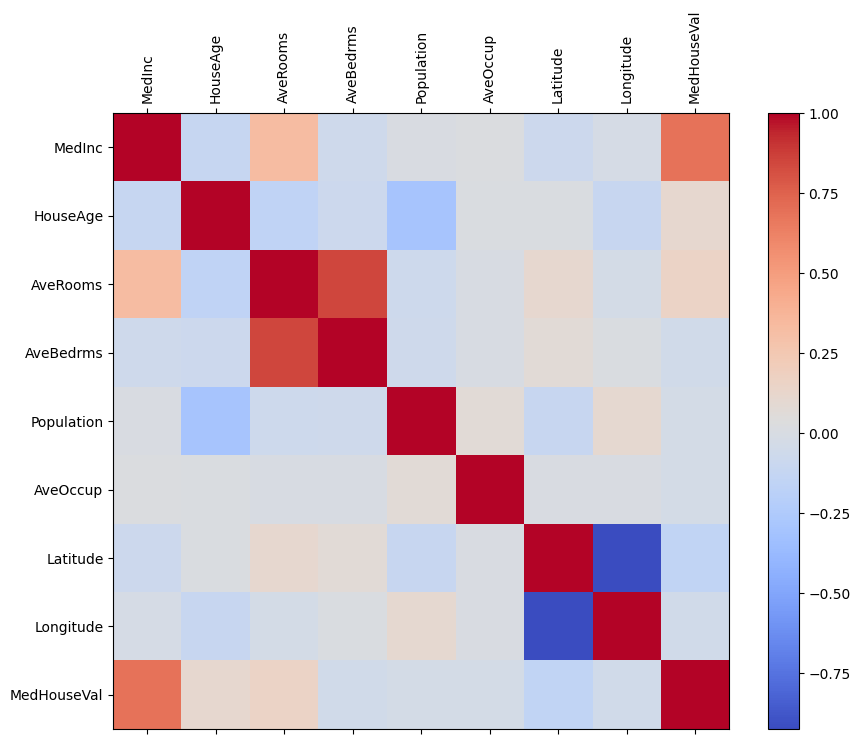

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap="coolwarm")

# Agregamos los nombres de las columnas como ticks
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Barra de colores
fig.colorbar(cax)

plt.show()


## Preprocesamiento de datos

Para el preprocesamiento de datos nos vamos a limitar a la normalización de los datos. La normalización es una técnica común en el aprendizaje automático para mejorar la convergencia y la estabilidad del modelo. En este caso, normalizaremos todas las variables a un rango de 0 a 1.

In [12]:
dfn = df.drop(
    columns=target_column_name
)  # Eliminar la columna objetivo 'MedHouseVal' del DataFrame y normalizar el resto de columnas
dfn = (dfn - dfn.mean()) / dfn.std()  # Normalizamos las columnas

dfn[target_column_name] = df[
    target_column_name
]  # Añadir la columna objetivo 'MedHouseVal' de nuevo al DataFrame normalizado

dfn.describe()  # Mostramos un resumen de las estadísticas del DataFrame normalizado

# Normalizamos para que todas las features esten al rededor de 0. Las redes neuronales convergen mas rapido cuando los inputs estan en escalas similares.
# El target no se normaliza

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,20640.000000
mean,4.406467e-17,1.101617e-17,6.885104e-17,-1.018995e-16,-1.514723e-17,2.754042e-18,-1.035520e-15,-8.526513e-15,2.068558
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.153956
min,-1.774256e+00,-2.196127e+00,-1.852274e+00,-1.610729e+00,-1.256092e+00,-2.289944e-01,-1.447533e+00,-2.385935e+00,0.149990
25%,-6.881019e-01,-8.453727e-01,-3.994399e-01,-1.911670e-01,-5.637952e-01,-6.170912e-02,-7.967694e-01,-1.113182e+00,1.196000
50%,-1.767908e-01,2.864502e-02,-8.078293e-02,-1.010626e-01,-2.291262e-01,-2.431526e-02,-6.422715e-01,5.389006e-01,1.797000
75%,4.592952e-01,6.642943e-01,2.519554e-01,6.015724e-03,2.644885e-01,2.037404e-02,9.729330e-01,7.784775e-01,2.647250
max,5.858144e+00,1.856137e+00,5.516190e+01,6.957003e+01,3.024960e+01,1.194162e+02,2.957996e+00,2.625216e+00,5.000010


## Dataset y DataLoader

**Dataset**

En PyTorch, un `Dataset` es una clase que se encarga de cargar y preparar los datos para su posterior uso en el entrenamiento de modelos. Este objeto almacena los datos y proporciona un método para acceder a ellos de manera eficiente y estructurada. Generalmente, `Dataset` se personaliza según el tipo de datos que se maneja, por ejemplo, imágenes, texto o series temporales. Su implementación básica requiere definir los métodos `__len__` para devolver el tamaño del dataset y `__getitem__` para acceder a un elemento específico.

Más información sobre `Dataset` en la documentación oficial de PyTorch: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

**DataLoader**

El `DataLoader` es una clase que se utiliza para envolver un objeto `Dataset` y proporciona un acceso fácil a los datos en lotes durante el entrenamiento, además de otras funcionalidades como el barajado (shuffling) de datos y la carga paralela utilizando múltiples subprocesos. Esto es crucial para el entrenamiento eficiente de modelos, especialmente con grandes volúmenes de datos, ya que gestiona el uso de memoria y mejora el rendimiento computacional.

Más información sobre `DataLoader` en la documentación oficial de PyTorch: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

**Objetivo y Uso**

El uso conjunto de `Dataset` y `DataLoader` en PyTorch es fundamental para el flujo de trabajo de entrenamiento de modelos de aprendizaje automático. `Dataset` se encarga de la estructura y accesibilidad de los datos, mientras que `DataLoader` optimiza el proceso de iteración sobre los datos en lotes y facilita operaciones como la mezcla y la carga paralela. Esto permite que el entrenamiento de modelos sea más escalable y eficiente.


### Datasets

In [13]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self, dataframe, target_column):
        # TODO
        self.x = dataframe.drop(columns=target_column).values  # devuelve tupla de datos
        self.y = dataframe[target_column].values

    def __len__(self):  # cantidad de samples
        # TODO
        return len(self.x)

    def __getitem__(self, idx):
        # TODO
        x = torch.tensor(self.x[idx], dtype=torch.float32)
        y = torch.tensor([self.y[idx]], dtype=torch.float32)  # a este le pongo los [] para forzar que sea una lista, porque es 1 solo numero
        return x, y # devuelvo tensores que aun no estan en GPU

dataset = CaliforniaHousingDataset(dfn, target_column_name)

In [14]:
len(dataset)

20640

In [15]:
dataset[0]

(tensor([ 2.3447,  0.9821,  0.6285, -0.1538, -0.9744, -0.0496,  1.0525, -1.3278]),
 tensor([4.5260]))

Dividimos el conjunto de datos en tres partes: entrenamiento, validación y prueba. La división se realiza de forma aleatoria, utilizando el 80% de los datos para entrenamiento, el 10% para validación y el 10% restante para pruebas.

In [16]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = (
    total_size - train_size - val_size
)  # nos aseguramos de que el tamaño del conjunto de test sea correcto

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [17]:
train_dataset[0]

(tensor([-0.9086, -0.1303, -0.9368, -0.0099,  1.0495, -0.0265, -0.6985,  0.6637]),
 tensor([2.2900]))

### DataLoaders

Definimos los dataloaders para cada conjunto de datos, estos son los que se encargan de cargar los datos en lotes durante el entrenamiento y la evaluación del modelo.

In [18]:
def get_data_loaders(batch_size, num_workers):

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers) # TODO

    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=num_workers) # TODO

    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=num_workers) # TODO

    return train_loader, val_loader, test_loader

# solo shuffleamos el trainig set porque el test y validation tienen que estar tal cual son, para que las pruebas reflejen resultado real

In [19]:
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE, NUM_WORKERS) # obtenemos los dataloaders

# probamos un batch del DataLoader
x_batch, y_batch = next(iter(train_loader)) # iter como el iterator de java, devuelve 1 dato por fila, 1024 respuestas por el batch size
print(x_batch.shape, y_batch.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([1024, 8]) torch.Size([1024, 1])


In [20]:
# pordemos recorrer un batch con un bucle
# aca vemos que el ultimo batch es de 128, podria usar drop_last en el DataLoader si no quiero que aparezca

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)

torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([1024, 8]) torch.Size([1024, 1])
torch.Size([128, 8]) torch.Size([128, 1])


## Modelo

A continuación, definimos un modelo de regresión lineal simple utilizando PyTorch.

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        # TODO
        self.input = nn.Linear(input_size, 64)
        self.hidden = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)
        return x


input_len = (
    len(dfn.columns) - 1
)  # Calculamos la cantidad de inputs como la cantidad de columnas -1 (el target)

summary(MLP(input_len), input_size=(BATCH_SIZE, input_len))

# Linear: fully connected layers ( z = xW.T + b )
# Output: 1 neurona -> predecimos house value

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1024, 1]                 --
├─Linear: 1-1                            [1024, 64]                576
├─Linear: 1-2                            [1024, 32]                2,080
├─Linear: 1-3                            [1024, 1]                 33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.75
Input size (MB): 0.03
Forward/backward pass size (MB): 0.79
Params size (MB): 0.01
Estimated Total Size (MB): 0.84

## Entrenamiento

Vamos a definir una función de entrenamiento que se encargará de iterar sobre los datos de entrenamiento, calcular las predicciones del modelo, calcular la pérdida y actualizar los pesos del modelo utilizando el optimizador.

Tamibén definimos una función de evaluación que se encargará de calcular la pérdida y otras métricas de evaluación en el conjunto de validación.

In [22]:
def evaluate(model, criterion, data_loader):
    """
    Evalúa el modelo en los datos proporcionados y calcula la pérdida promedio.

    Args:
        model (torch.nn.Module): El modelo que se va a evaluar.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        data_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de evaluación.

    Returns:
        float: La pérdida promedio en el conjunto de datos de evaluación.

    """
    avg_loss = 0
    # TODO
    model.eval()

    with torch.no_grad():
      for x,y in data_loader:
        # movemos tensores de CPU a GPU
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # calculamos la loss ; recordar que tiene el grafo de computo
        output = model(x)
        loss = criterion(output, y) # escalar dentro del tensor

        avg_loss += loss.item() # item() extrae valor escalar del tensor

    avg_loss /= len(data_loader)

    return avg_loss


def train(
    model,
    optimizer,
    criterion,  # funcion de loss
    train_loader,
    val_loader,
    epochs=10,
    log_fn=None,
    log_every=1,  # cada tantas epocas logueo
):
    """
    Entrena el modelo utilizando el optimizador y la función de pérdida proporcionados.

    Args:
        model (torch.nn.Module): El modelo que se va a entrenar.
        optimizer (torch.optim.Optimizer): El optimizador que se utilizará para actualizar los pesos del modelo.
        criterion (torch.nn.Module): La función de pérdida que se utilizará para calcular la pérdida.
        train_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de entrenamiento.
        val_loader (torch.utils.data.DataLoader): DataLoader que proporciona los datos de validación.
        epochs (int): Número de épocas de entrenamiento (default: 10).
        log_fn (function): Función que se llamará después de cada log_every épocas con los argumentos (epoch, train_loss, val_loss) (default: None).
        log_every (int): Número de épocas entre cada llamada a log_fn (default: 1).

    Returns:
        Tuple[List[float], List[float]]: Una tupla con dos listas, la primera con el error de entrenamiento de cada época y la segunda con el error de validación de cada época.

    """
    epoch_train_errors = []  # colectamos el error de traing para posterior analisis
    epoch_val_errors = []  # colectamos el error de validacion para posterior analisis

    # TODO
    for epoch in range(epochs):
      model.train() # buena practica, no hace falta en esta red que estamos haciendo
      epoch_train_loss = 0

      for x,y in train_loader:
        # movemos tensores de CPU a GPU
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # limpiamos gradientes
        optimizer.zero_grad()

        # calculamos la loss ; recordar que tiene el grafo de computo
        output = model(x)
        loss = criterion(output, y) # escalar
        loss.backward()
        optimizer.step()  # cambia pesos
        epoch_train_loss += loss.item()

      epoch_train_loss /= len(train_loader) # promedio de las losses por epoch
      epoch_train_errors.append(epoch_train_loss)

      epoch_val_loss = evaluate(model, criterion, val_loader)
      epoch_val_errors.append(epoch_val_loss)

      # logueamos si corresponde la epoca
      if log_fn is not None and (epoch + 1) % log_every == 0:
        log_fn(epoch + 1, epoch_train_loss, epoch_val_loss)


    return epoch_train_errors, epoch_val_errors

Definimos hiperparámetros como el número de épocas, la tasa de aprendizaje y la función de pérdida.

In [23]:
# Definimos los hiperparámetros
LR = 0.01
CRITERION = nn.MSELoss().to(DEVICE)
EPOCHS = 100

In [24]:
def print_log(epoch, train_loss, val_loss):
    print(
        f"Epoch: {epoch:03d}/{EPOCHS:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}"
    )

model = MLP(input_len).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, print_log, 5
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 005/100 | Train Loss: 0.75515 | Val Loss: 0.57919
Epoch: 010/100 | Train Loss: 0.65015 | Val Loss: 0.52711
Epoch: 015/100 | Train Loss: 0.60424 | Val Loss: 0.49556
Epoch: 020/100 | Train Loss: 0.56703 | Val Loss: 0.46605
Epoch: 025/100 | Train Loss: 0.52588 | Val Loss: 0.43763
Epoch: 030/100 | Train Loss: 0.51034 | Val Loss: 0.42313
Epoch: 035/100 | Train Loss: 0.48589 | Val Loss: 0.41134
Epoch: 040/100 | Train Loss: 0.46290 | Val Loss: 0.40054
Epoch: 045/100 | Train Loss: 0.45436 | Val Loss: 0.39279
Epoch: 050/100 | Train Loss: 0.44279 | Val Loss: 0.39014
Epoch: 055/100 | Train Loss: 0.43026 | Val Loss: 0.38879
Epoch: 060/100 | Train Loss: 0.41624 | Val Loss: 0.37486
Epoch: 065/100 | Train Loss: 0.40467 | Val Loss: 0.36903
Epoch: 070/100 | Train Loss: 0.39854 | Val Loss: 0.36691
Epoch: 075/100 | Train Loss: 0.39954 | Val Loss: 0.36514
Epoch: 080/100 | Train Loss: 0.38852 | Val Loss: 0.35995
Epoch: 085/100 | Train Loss: 0.39079 | Val Loss: 0.35838
Epoch: 090/100 | Train Loss: 0.

### Loss durante el entrenamiento

Es importante tener en cuenta que la pérdida es una medida de cuán bien se está desempeñando el modelo en el conjunto de entrenamiento. Sin embargo, la pérdida por sí sola no proporciona una visión completa del rendimiento del modelo. Por lo tanto, es fundamental evaluar el modelo en un conjunto de validación independiente para obtener una idea más precisa de su capacidad para generalizar a datos no vistos.

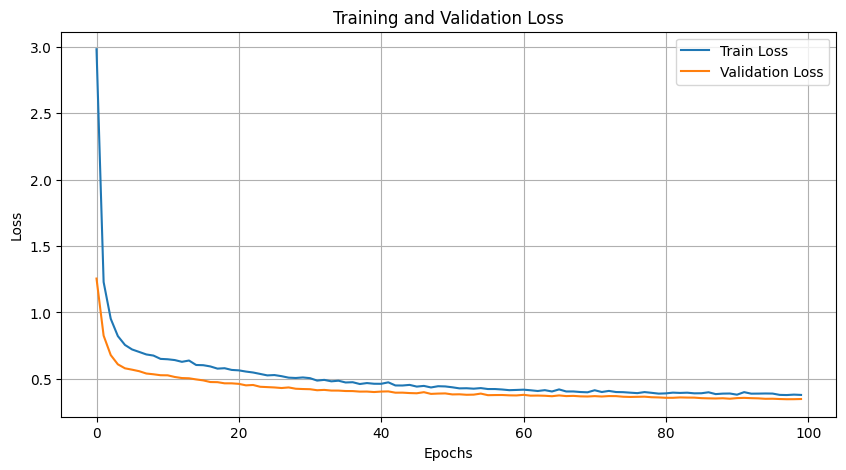

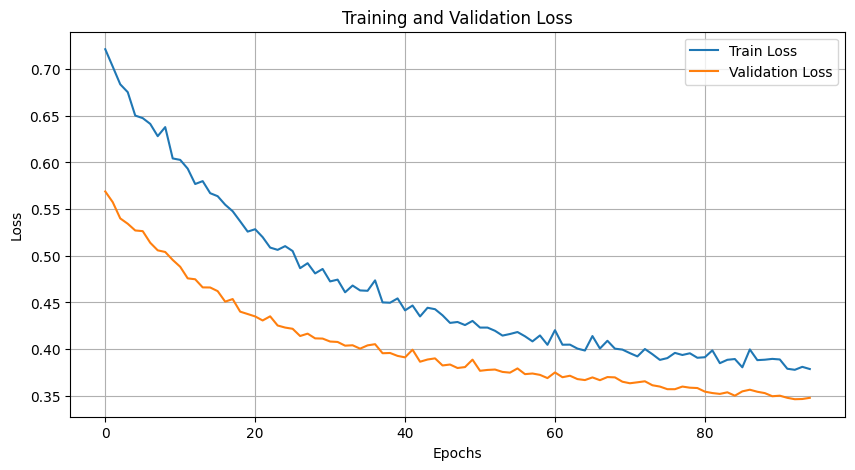

In [25]:
def plot_taining(train_errors, val_errors):
    # Graficar los errores
    plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
    plt.plot(train_errors, label="Train Loss")  # Grafica la pérdida de entrenamiento
    plt.plot(val_errors, label="Validation Loss")  # Grafica la pérdida de validación
    plt.title("Training and Validation Loss")  # Título del gráfico
    plt.xlabel("Epochs")  # Etiqueta del eje X
    plt.ylabel("Loss")  # Etiqueta del eje Y
    plt.legend()  # Añade una leyenda
    plt.grid(True)  # Añade una cuadrícula para facilitar la visualización
    plt.show()  # Muestra el gráfico


plot_taining(epoch_train_errors, epoch_val_errors) # graficamos los errores

plot_taining(epoch_train_errors[5:], epoch_val_errors[5:]) # graficamos los errores a partir de la epoca 5 (para ver mejor)

# Cuando graficamos train loss vs validation loss podemos ver el comportamiento del modelo:
# Si ambas curvas bajan juntas: esta aprendiendo bien
# Si baja train pero sube val: OVERFITTING
# Si ambos son altos o no se mueven: UNDERFITTING

## Weight and Bias (W&B)

Weight and Bias es una plataforma que facilita el seguimiento, visualización y colaboración en experimentos de aprendizaje automático. Permite registrar métricas, gráficos y modelos de manera centralizada para facilitar el análisis y la comprensión de los resultados obtenidos durante el entrenamiento de modelos.

**Funcionalidades Principales**

1. **Seguimiento de Experimentos:** Permite registrar métricas clave como pérdida y precisión a lo largo del entrenamiento para cada experimento.

2. **Visualización Interactiva:** Proporciona gráficos dinámicos para explorar la evolución de métricas y comparar diferentes experimentos de manera intuitiva.

3. **Colaboración y Reproducibilidad:** Facilita compartir resultados con colegas y mantener un registro detallado de todos los experimentos realizados.

> Se requiere una cuenta de W&B, asi como crear un team/equipe y un proyecto para poder utilizar la plataforma. Para más información, visite: https://wandb.ai/site

In [26]:
import wandb

wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mc241319 (mc-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Sweeps en Weight and Bias

Uno de los aspectos destacados de Weight and Bias son los "sweeps". Estos permiten explorar múltiples combinaciones de hiperparámetros de manera automática, registrando y comparando los resultados de cada configuración. Algunas características de los sweeps incluyen:

- **Automatización de Experimentos:** Ejecución paralela de múltiples configuraciones de hiperparámetros para optimizar el rendimiento del modelo.

- **Análisis de Resultados:** Visualización automática de los resultados de cada configuración para identificar la mejor combinación de hiperparámetros.

- **Ajuste Eficiente:** Permite ajustar rápidamente los hiperparámetros sin necesidad de intervención manual intensiva.

Más información sobre Weight and Bias en la documentación oficial: https://docs.wandb.ai/guides/sweeps

In [27]:
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "California house pricing"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "sweep-california-housing",
    "method": "random",   # samples random combinations. Otras opciones: grid (exhaustively tests all combinations) ; bayes (adaptive bayesian optimization)
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 256, 1024, 4096]},
    },
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: w8vwkege
Sweep URL: https://wandb.ai/mc-ort/California%20house%20pricing/sweeps/w8vwkege


### Función Run

La función `run` de W&B se utiliza para iniciar un experimento y registrar métricas clave, hiperparámetros y otros detalles relevantes. Esta función se utiliza para rastrear y visualizar los resultados de los experimentos en la plataforma W&B.

In [28]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_batch_size = config.batch_size

    # TODO
    # dataloaders
    train_loader, val_loader, _ = get_data_loaders(run_batch_size, NUM_WORKERS)

    # modelo
    model = MLP(input_len).to(DEVICE) # es el mismo modelo que habiamos definido antes, por ahora no cambiamos nada de esto

    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)
    elif run_optimizer == "sgd":
      optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    train(model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, wand_log, 1)

    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

### Corremos el Sweep

Para ejecutar un sweep, creamos un agente que le pide a W&B un conjunto de hiperparámetros para cada experimento. Luego, ejecutamos cada experimento con esos hiperparámetros y registramos los resultados en W&B.

Es importante que podemos ejecutar en varios entornos, incluso al mismo tiempo, para explorar diferentes configuraciones de hiperparámetros y comparar los resultados.

In [29]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: 3p0kzw2m with config:
wandb: 	batch_size: 1024
wandb: 	learning_rate: 0.0033494196625527884
wandb: 	optimizer: sgd


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,101
train_loss,0.47995
val_loss,0.41029


wandb: Agent Starting Run: jgkkqad8 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.057492696625268326
wandb: 	optimizer: sgd


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
train_loss,█▆▅▅▄▃▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▅▄▆▄▃▃▃▃▃▃▃▃▃▃▃▂▂▅▂▂▂▄▂▄▁▂▁▂▁▃▁▂▆▁▂▁
epoch,101
train_loss,0.26137
val_loss,0.28216


wandb: Agent Starting Run: p36bbymu with config:
wandb: 	batch_size: 4096
wandb: 	learning_rate: 0.036481288716315945
wandb: 	optimizer: sgd


epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▇▇▇▅▆▅▅▅▅▄▅▃▃▃▂▃▃▃▃▂▂▂▁▁▂▂▂▁▁▁▂▂▁▂▁▁▁▂▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,101
train_loss,0.38324
val_loss,0.40864


wandb: Agent Starting Run: i2j5i53q with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.09042393481337745
wandb: 	optimizer: sgd


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
+2,...
epoch,101
train_loss,nan
val_loss,nan


wandb: Agent Starting Run: x8qsqkhx with config:
wandb: 	batch_size: 1024
wandb: 	learning_rate: 0.07761780777451682
wandb: 	optimizer: adam


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▃▃▃▄▃▂▂▁▁▁▃▁▁▁▁▂▁▂▁▂▂▁▁▂▁▂▂▂▂▁▁▁▁▁▂▃
epoch,101
train_loss,0.26432
val_loss,0.2746


wandb: Agent Starting Run: id1phdb8 with config:
wandb: 	batch_size: 256
wandb: 	learning_rate: 0.0007896717718768099
wandb: 	optimizer: sgd


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,101
train_loss,0.47814
val_loss,0.45747


wandb: Agent Starting Run: yomjca2o with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.08703727353205017
wandb: 	optimizer: sgd


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▆▇▅▄▄▄▃▃▄▃▃█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,▇▇█▄▅▅▄▃▂▂▄▂▂▂▆▂▂▂▁▂▂▄▂▂▂▁▂▁▁▂█▁▂▂▂▂▁▄▃▁
epoch,101
train_loss,0.25234
val_loss,0.29279


wandb: Agent Starting Run: rhrs2nsl with config:
wandb: 	batch_size: 1024
wandb: 	learning_rate: 0.07977335446190008
wandb: 	optimizer: sgd


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss,███▇▇▆▅▆▄▅▄▇▅▅▄▂▄▅▃▃▃▂▃▅▃▃▂▂▃▂▂▃▂▃▂▃▁▂▁▁
val_loss,▇█▆▅▆▇▇▅▇█▆█▄▃▆▃▅▃▅▄▅▃▂▆▄▂▂▄▄▄▂▃▂▃▁▂▁▁▇▂
epoch,101
train_loss,0.30534
val_loss,0.32226


wandb: Agent Starting Run: 957j3fd0 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.06791860319877824
wandb: 	optimizer: adam


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
train_loss,▂▁▁█▂▂▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▁▄▆▅▃▁▃▄▂▂▃▂▁▁▂▂▃█▂▁▄▁▄▅▂▂▅▁▁▂▂▂▃▃▂▆▃▁
epoch,101
train_loss,0.39616
val_loss,0.38857


wandb: Agent Starting Run: dlisn34w with config:
wandb: 	batch_size: 4096
wandb: 	learning_rate: 0.0525374265368741
wandb: 	optimizer: adam


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
train_loss,█▆▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,101
train_loss,0.27443
val_loss,0.32582


## Mejor Modelo

Una vez que hemos ejecutado el sweep y registrado los resultados en W&B, podemos identificar el mejor modelo basado en las métricas de evaluación.

In [30]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by +summary_metrics.val_loss


Best run earnest-sweep-5 with 0.2746029943227768


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='utf-8'>

## Evaluación final

Finalmente, evaluamos el mejor modelo en el conjunto de prueba y visualizamos los resultados obtenidos.

In [31]:
# restauramos el modelo
model.load_state_dict(torch.load("model.pth"))

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(model, CRITERION, test_loader)

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 0.26309


## Ejercicios


1. **Expansión de la Configuración del Sweep**:
   - **Objetivo**: Ampliar la configuración del sweep existente para incluir la exploración de nuevas arquitecturas de red neuronal.
   - **Instrucción**: Expanda el `sweep_config` para incluir parámetros relacionados con la arquitectura del modelo, como el número de capas ocultas (`hidden_layers`) y el número de neuronas por capa (`neurons_per_layer`). Establezca un rango razonable para estos parámetros, por ejemplo, de 1 a 4 para las capas ocultas y de 16 a 128 para las neuronas por capa. Luego, ejecute el sweep y utilice W&B para analizar cómo estos cambios en la arquitectura afectan la métrica de pérdida de validación (`val_loss`).

2. **Experimentación con Funciones de Activación**:
   - **Objetivo**: Evaluar cómo diferentes funciones de activación afectan el rendimiento del modelo.
   - **Instrucción**: Añada una nueva variable a la configuración del sweep para probar diferentes funciones de activación (por ejemplo, ReLU, tanh, sigmoid). Modifique el `sweep_config` para incluir un parámetro `activation_function` con valores posibles como ["relu", "tanh", "sigmoid"]. Ejecute el sweep para explorar cuál función de activación resulta en un mejor rendimiento para el modelo y justifique los resultados basándose en las visualizaciones y métricas registradas en W&B.


```python
sweep_config = {
    "name": "sweep-california-housing-expanded-architecture",
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 256, 1024, 4096]},
        "hidden_layers": {"values": [1, 2, 3, 4]},  # Número de capas ocultas
        "neurons_per_layer": {"values": [16, 32, 64, 128]},  # Número de neuronas por capa
        "activation_function": {"values": ["relu", "tanh", "sigmoid"]}  # Función de activación
    },
}
```

In [32]:
WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "California house pricing"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "sweep-california-housing-expanded-architecture",
    "method": "random",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
        "batch_size": {"values": [32, 256, 1024, 4096]},

        "hidden_layers": {"values": [1, 2, 3, 4]},  # Número de capas ocultas
        "neurons_per_layer": {"values": [16, 32, 64, 128]},  # Número de neuronas por capa

        "activation_function": {"values": ["relu", "tanh", "sigmoid"]}  # Función de activación"
    },
    "early_terminate": {"type": "hyperband", "min_iter": 5, "eta": 3}
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: zj880d2m
Sweep URL: https://wandb.ai/mc-ort/California%20house%20pricing/sweeps/zj880d2m


In [33]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()

    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_batch_size = config.batch_size
    # nueva config
    run_hidden_layers = int(config.hidden_layers)
    run_width         = int(config.neurons_per_layer)
    run_activation    = str(config.activation_function)

    # dataloaders
    train_loader, val_loader, _ = get_data_loaders(run_batch_size, NUM_WORKERS)

    # funcion de activacion
    if   run_activation == "relu":    Act = nn.ReLU
    elif run_activation == "tanh":    Act = nn.Tanh
    elif run_activation == "sigmoid": Act = nn.Sigmoid

    # modelo
    # ahora cambia arquitectura, no podemos usar model = MLP(input_len).to(DEVICE)
    layers = []
    prev = input_len  # current size va a ser el input size de la proxima layer
    # agrego N hidden layers
    for _ in range(int(run_hidden_layers)):
      layers.append(nn.Linear(prev, run_width))
      layers.append(Act())
      prev = run_width
    layers.append(nn.Linear(prev, 1)) # output layer

    model = nn.Sequential(*layers)  # *layers expande la lista y se la pasa en orden a nn.Sequential
    model = model.to(DEVICE)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)
    elif run_optimizer == "sgd":
      optimizer = optim.SGD(model.parameters(), lr=run_learning_rate)

    train(model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, wand_log, 1)

    # guardo pesos temporalmente
    fname = f"model_{wandb.run.id}.pth"
    torch.save(model.state_dict(), fname)
    wandb.save(fname)

    wandb.finish()

In [34]:
wandb.agent(sweep_id, function=sweep_run, count=3)

wandb: Agent Starting Run: ef0eq5q5 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.011122148758422136
wandb: 	neurons_per_layer: 64
wandb: 	optimizer: adam


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▃▂▂▂▃▁▂▁▁▁▂▁▂▂▁▁▁▂▁▁▁▂▂▁▁▂▂▂▂▂▁▃▃▂
epoch,101
train_loss,0.16314
val_loss,0.29573


wandb: Agent Starting Run: goeirbe2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.08766200988611308
wandb: 	neurons_per_layer: 32
wandb: 	optimizer: adam


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-2943135815.py", line 50, in sweep_run
    train(model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, wand_log, 1)
  File "/tmp/ipython-input-2728574526.py", line 81, in train
    loss.backward()
  File "/usr/local/lib/python3.12/dist-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Exception



epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▁▁▁▅▃▁▂▁▂▁
val_loss,▂▁▇▁▅▁▅▄▄█▂
epoch,12
train_loss,0.82421
val_loss,0.73706


wandb: Agent Starting Run: 1pdv901z with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	hidden_layers: 2
wandb: 	learning_rate: 0.0633487958645596
wandb: 	neurons_per_layer: 32
wandb: 	optimizer: adam


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 297, in _run_job
    self._function()
  File "/tmp/ipython-input-2943135815.py", line 50, in sweep_run
    train(model, optimizer, CRITERION, train_loader, val_loader, EPOCHS, wand_log, 1)
  File "/tmp/ipython-input-2728574526.py", line 70, in train
    for x,y in train_loader:
               ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 494, in __iter__
    return self._get_iterator()
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 427, in _get_iterator
    return _MultiProcessingDataLoaderIter(self)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1228, in __init__
    self._reset(loader, first_iter=True)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/dat

epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▂▅▃▂▂▅▁▃▁▂▄▃▄▂▃▃▄▄▂▃▂▄▄▄▃▂▃▂▃▄▂▄▆▂
epoch,69
train_loss,0.26712
val_loss,0.32488


In [35]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
fname = f"model_{best_run.id}.pth"
try:
    best_run.file(fname).download(replace=True)
except Exception:
    # Fallback: find any .pth saved for this run
    pth_files = [f for f in best_run.files() if f.name.endswith(".pth")]
    if not pth_files:
        raise RuntimeError("No .pth file found for best run.")
    fname = pth_files[0].name
    pth_files[0].download(replace=True)

wandb: Sorting runs by +summary_metrics.val_loss


Best run desert-sweep-1 with 0.29572755429479813


In [36]:
# 1) Rebuild the exact architecture from best_run.config (unchanged from earlier)
cfg = best_run.config
Act = {"relu": nn.ReLU, "tanh": nn.Tanh, "sigmoid": nn.Sigmoid}[cfg["activation_function"]]
layers, prev = [], input_len
for _ in range(int(cfg["hidden_layers"])):
    layers += [nn.Linear(prev, int(cfg["neurons_per_layer"])), Act()]
    prev = int(cfg["neurons_per_layer"])
layers += [nn.Linear(prev, 1)]
model = nn.Sequential(*layers).to(DEVICE)  # Sequential chains modules left→right. :contentReference[oaicite:1]{index=1}

# 2) Restore weights using the actual downloaded filename
state = torch.load(fname, map_location=DEVICE)  # <- use fname from the download step
model.load_state_dict(state)

# 3) Evaluate on test
test_loss = evaluate(model, CRITERION, test_loader)
print(f"Test Loss: {test_loss:.5f}")


Test Loss: 0.24096
